In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from myst_nb import glue 

from plastockmethods import name_the_zones, name_the_particles, frequentation_name, situation_name
from plastockmethods import particle_groups, name_the_substrate, name_the_distance, table_css_styles

def translate_describe(x, value_column):
    described = x.to_dict()
    described.pop("count")
    described["moyenne"] = described.pop("mean")
    described["écart-type"] = described.pop("std")
    df = pd.DataFrame(described.items())
    df.set_index(0, inplace=True)
    df.rename(columns={1:value_column}, inplace=True)
    df.index.name = None
    
    
    return df

work_data = pd.read_csv("data/end_pipe/long_form_micro.csv")
wide_form = pd.read_csv("data/end_pipe/aggregated_micro_results.csv")
beach_data = pd.read_csv("data/end_pipe/asl_beaches.csv")

# Résultats par plage et position

__Résultats agrégés par texture, position et échantillon__

In [2]:
caption = "Les données sont regroupées en trois groupes par échantillon: 1. fibres, 2. fragments rigides, 3. fragments souples."

work_data[work_data.echantillon == "74_Amp_2"].head().style.set_table_styles(table_css_styles).set_caption(caption)

,Plage,echantillon,orientation,position,substrat,frequentation,situation,distance,objet,compte
2,Amphion,74_Amp_2,NNE,1,4,3,1,1,fibres,121
219,Amphion,74_Amp_2,NNE,1,4,3,1,1,fdure,3
436,Amphion,74_Amp_2,NNE,1,4,3,1,1,souple,12


## Nombre cumulé d'échantillons et décompte par plage

In [3]:
location_summary = work_data.groupby("Plage", as_index=False).agg({"echantillon": "nunique", "compte":"sum"})
location_summary["poids echantillon"] = location_summary.echantillon/location_summary.echantillon.sum()
location_summary["poids compte"] = location_summary.compte/location_summary.compte.sum()
# location_summary.set_index("Plage", inplace=True, drop=True)
df1 = location_summary.copy()
df1.set_index("Plage", inplace=True, drop=True)
df1.index.name = None
a_property =  {'color' : 'red'}

select_values = df1["poids echantillon"] < df1["poids compte"]
test_one = df1.loc[select_values].index
caption = "Nombre cumulé d'échantillons et le total par plage. Les plages où le poids du comptage est supérieur au poids des échantillons sont en rouge."
                        
df1.style.set_table_styles(table_css_styles).format(precision=2).set_caption(caption).set_properties(subset = pd.IndexSlice[test_one,["poids echantillon", "poids compte"]], **a_property)

,echantillon,compte,poids echantillon,poids compte
Amphion,10,1250,0.05,0.03
Anthy,6,685,0.03,0.02
Aubonne,8,757,0.04,0.02
Baby Plage,11,1288,0.05,0.03
Bouveret,12,2114,0.06,0.05
Clarens,6,415,0.03,0.01
Crans,1,19,0.00,0.00
Cully,2,128,0.01,0.00
Excenevex,28,3775,0.13,0.10
Gland,1,40,0.00,0.00


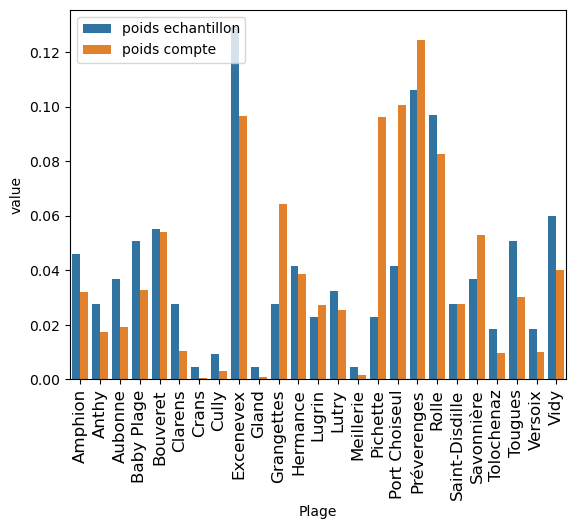

In [4]:
bar_plots = pd.melt(location_summary, id_vars="Plage", value_vars=["poids echantillon", "poids compte"])
fig, ax = plt.subplots()
sns.barplot(data=bar_plots, x="Plage", y="value", hue="variable", ax=ax)
ax.legend(loc="upper left")
ax.tick_params(axis="x", labelrotation=90, labelright=True, labelsize=12 )
plt.show()

In [5]:
attribute_columns = ["Plage", "orientation", "position", "substrat", "frequentation", "situation", "distance"]
percent_of_samples = df1.loc[select_values].echantillon.sum()/location_summary.echantillon.sum()
attributes_of_samples = work_data[work_data.Plage.isin(test_one)].drop_duplicates(["Plage"])


def translate_columns(data, columns, keys):
    
    for i, column in enumerate(columns):
        
        data[column] = data[column].apply(lambda x: keys[i][x])
    
    return data

attribute_keys = [name_the_zones, name_the_substrate, frequentation_name, situation_name, name_the_distance]
caption = "Les plages et leurs attributs où le poids du comptage est supérieur au poids des échantillons."    

display_df = translate_columns(attributes_of_samples, attribute_columns[2:], attribute_keys)
display_df[attribute_columns].style.set_table_styles(table_css_styles).set_caption(caption)

,Plage,orientation,position,substrat,frequentation,situation,distance
44,Lugrin,NNE,ligne-d'eau,galet,moyenne,campagne,100 - 500m
87,Port Choiseul,NE,ligne-d'eau,gravier,élévée,urbain,100 - 500m
96,Savonnière,NO,ligne-d'eau,galet,élévée,campagne,< 100m
126,Grangettes,NO,ligne-d'eau,sable fin,moyenne,campagne,100 - 500m
139,Pichette,SSE,ligne-d'eau,gravier,moyenne,campagne,< 100m
144,Préverenges,SO,ligne-d'eau,sable fin,élévée,campagne,100 - 500m


## Compte moyen par échantillon et plage

In [6]:
sample_totals = work_data.groupby(["Plage","echantillon"], as_index=False).compte.sum()
df2 = sample_totals.copy()
value_column = "moyenne"

summary_comptes = sample_totals.compte.describe()

summary_comptes_display =  translate_describe(summary_comptes, "compte").style.set_table_styles(table_css_styles).format(precision=2)
summary_comptes_display.set_caption("Valeurs récapitulatives des totaux des échantillons.")

,compte
min,0.00
25%,70.00
50%,121.00
75%,198.00
max,2991.00
moyenne,180.13
écart-type,267.62


In [7]:
sample_averages = df2.groupby("Plage", as_index=False).agg({"echantillon": "nunique", "compte":"mean"})
average_of_sample_totals = df2.compte.mean()
sample_averages.rename(columns={"compte":value_column}, inplace=True)
sample_averages.set_index("Plage", inplace=True, drop=True)
sample_averages.index.name = None

select_values = sample_averages[value_column] > average_of_sample_totals
test_two = sample_averages.loc[select_values].index
caption_one = "Nombre cumulé d'échantillons et total moyen de d'échantillon par plage."
caption_two = " Les plages dont la moyenne des résultats est supérieur à la moyenne par échantillon du projet sont en rouge."
caption_three = f"Moyenne du projet: {round(average_of_sample_totals, 2)}"
caption = f'{caption_one} {caption_two} {caption_three}'

sa = sample_averages.style.set_table_styles(table_css_styles).set_caption(caption).format(precision=2)
sa.set_properties(subset = pd.IndexSlice[test_two,[value_column]], **a_property)

,echantillon,moyenne
Amphion,10,125.00
Anthy,6,114.17
Aubonne,8,94.62
Baby Plage,11,117.09
Bouveret,12,176.17
Clarens,6,69.17
Crans,1,19.00
Cully,2,64.00
Excenevex,28,134.82
Gland,1,40.00


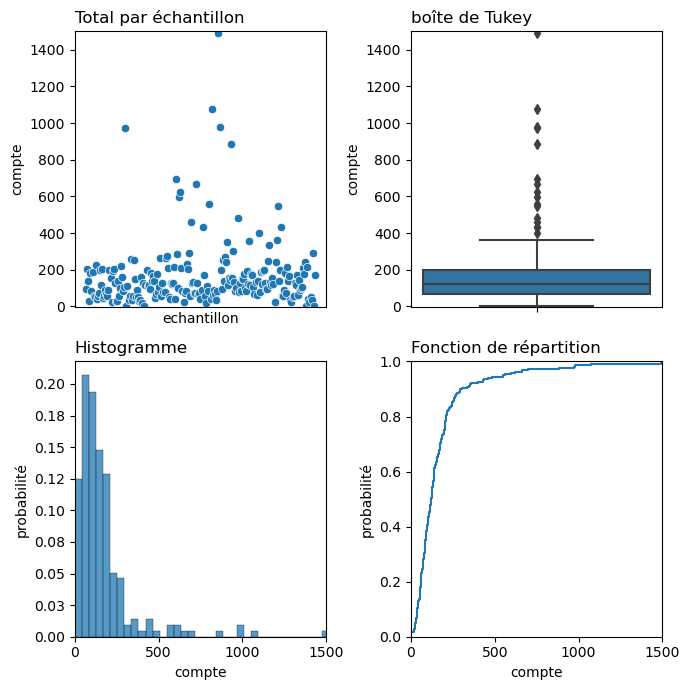

In [8]:
fig, ax = plt.subplots(2,2, figsize=(7,7))

sns.scatterplot(data=sample_totals, x="echantillon", y="compte", ax=ax[0,0])
ax[0,0].tick_params(labelbottom=False, bottom=False)
ax[0,0].set_ylim(-1, 1500)
ax[0,0].set_title("Total par échantillon", loc="left")

sns.boxplot(data=sample_totals, y="compte", dodge=False, width=.9, ax=ax[0,1])
ax[0,1].set_ylim(-1, 1500)
ax[0,1].set_title("boîte de Tukey", loc="left")

sns.histplot(data=sample_totals, x="compte", ax=ax[1,0], stat="probability")
ax[1,0].set_xlim(-1, 1500)
ax[1,0].yaxis.set_major_formatter('{x:.2f}')
ax[1,0].set_ylabel("probabilité")
ax[1,0].set_title("Histogramme", loc="left")

sns.ecdfplot(data=sample_totals, x="compte", ax=ax[1,1])
ax[1,1].set_xlim(-1, 1500)
ax[1,1].set_ylabel("probabilité")
ax[1,1].set_title("Fonction de répartition", loc="left")
plt.tight_layout()

plt.show()

## Comptes moyenne par position 

In [9]:
position_totals = work_data.groupby(["Plage","echantillon", "position"], as_index=False).compte.sum()
position_totals["position"] = position_totals.position.apply(lambda x: name_the_zones[x])
# position_totals["objet"] = position_totals.objet.apply(lambda x: particle_groups[x])
df4 = position_totals.groupby(["Plage","position"], as_index=False).compte.mean()

df4 = df4.pivot(index="Plage", columns=["position"])
df4.index.name = None
df4.columns
df4.fillna(0, inplace=True)

caption_one = "Le résultat moyen de d’échantillon par position."
caption_two = "Les plages dont la moyenne des résultats est supérieure à la moyenne du projet sont en rouge."
caption_three = f"Moyenne du projet: {round(average_of_sample_totals, 2)}"
caption = f"{caption_one} {caption_two} {caption_three}"

def select_a_set_of_values(data, column_one, threshold_data):
    
    return data.loc[data[column_one] > threshold_data]

position_columns = list(name_the_zones.values())
fragment_columns = list(particle_groups.values())

args = [("compte", x) for x in position_columns]



water_line = select_a_set_of_values(df4, args[0], average_of_sample_totals).index
plage_seche = select_a_set_of_values(df4, args[1], average_of_sample_totals).index

sax = df4.style.set_table_styles(table_css_styles).set_caption(caption).format(precision=2)
 
sax = sax.set_properties(subset = pd.IndexSlice[water_line,args[0]], **a_property)
sax = sax.set_properties(subset = pd.IndexSlice[plage_seche,args[1]], **a_property)

position_sample_totals = position_totals.groupby(["echantillon", "Plage", "position"], as_index=False).compte.sum()

summary_ligne_deau = position_sample_totals[position_sample_totals.position == "ligne-d'eau"].compte.describe()
summary_plage_seche = position_sample_totals[position_sample_totals.position == "plage-seche"].compte.describe()

ligne_deau_display =  translate_describe(summary_ligne_deau, "compte ligne d'eau").style.set_table_styles(table_css_styles).format(precision=2)
plage_seche_display =  translate_describe(summary_plage_seche, "compte plage-seche").style.set_table_styles(table_css_styles).format(precision=2)

glue("summary_ligne_deau", ligne_deau_display, display=False)
glue("summary_plage_seche", plage_seche_display, display=False)

|Ligne d'eau|Plage seche|
|:----------:|:----------:|
|{glue:}`summary_ligne_deau`|{glue:}`summary_plage_seche`|

In [10]:
sax

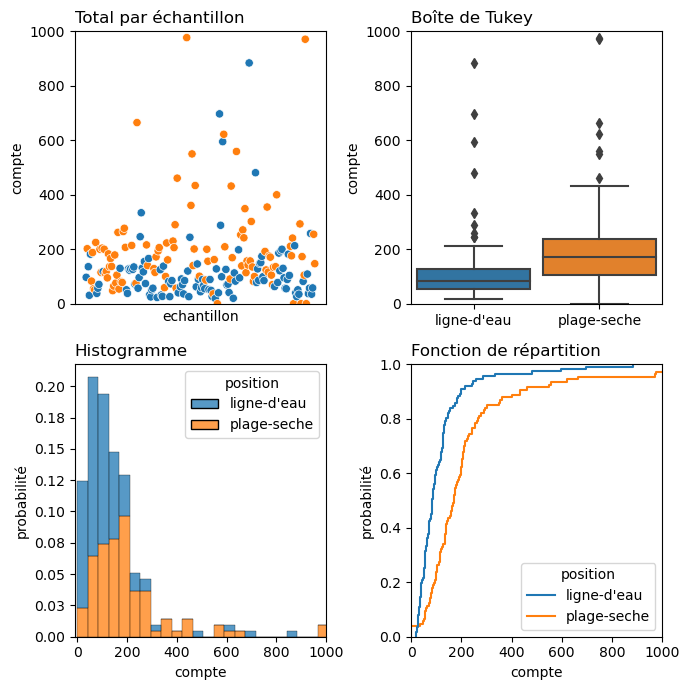

In [11]:
fig, ax = plt.subplots(2,2, figsize=(7,7))

d_position = position_totals.groupby(["echantillon", "position"], as_index=False).compte.sum()

sns.scatterplot(data=d_position, x="echantillon", y="compte", hue="position", ax=ax[0,0])
ax[0,0].tick_params(labelbottom=False, bottom=False)
ax[0,0].set_ylim(-1, 1000)
ax[0,0].set_title("Total par échantillon", loc="left")
ax[0,0].legend().remove()

sns.boxplot(data=d_position, x="position", y="compte", hue="position", dodge=False, width=.9, ax=ax[0,1])
ax[0,1].set_ylim(-1, 1000)
ax[0,1].set_title("Boîte de Tukey", loc="left")
ax[0,1].set_xlabel("")
ax[0,1].legend().remove()

sns.histplot(data=d_position, x="compte", hue="position", ax=ax[1,0], multiple="stack", stat="probability")
ax[1,0].set_xlim(-10, 1000)
ax[1,0].yaxis.set_major_formatter('{x:.2f}')
ax[1,0].set_ylabel("probabilité")
ax[1,0].set_title("Histogramme", loc="left")



sns.ecdfplot(data=d_position, x="compte", hue="position", ax=ax[1,1])
ax[1,1].set_xlim(-1, 1000)
ax[1,1].set_ylabel("probabilité")
ax[1,1].set_title("Fonction de répartition", loc="left")

plt.tight_layout()


plt.show()

### Nombre moyen par texture et plage

In [12]:
texture_totals = work_data.groupby(["Plage","echantillon", "objet"], as_index=False).compte.sum()
df3 = texture_totals.copy()

texture_averages = df3.groupby(["Plage", "objet"], as_index=False).agg({"compte":"mean"})
texture_averages.rename(columns={"compte":value_column}, inplace=True)
average_of_sample_textures = df3.groupby(["objet"], as_index=True).agg({"compte":"mean"})
average_of_sample_textures.rename(columns={"compte":value_column}, inplace=True)
average_of_sample_textures.index.name = None
caption = "La moyenne de l'échantillon du projet par type d'objet"
average_of_sample_textures.style.format(precision=2).set_table_styles(table_css_styles).set_caption(caption)

,moyenne
fdure,23.53
fibres,137.83
souple,18.78


In [13]:
tex_dure = texture_totals[texture_totals.objet=="fdure"].compte.describe()
rigid_display = translate_describe(tex_dure, "fragments rigides").style.set_table_styles(table_css_styles).format(precision=2)

tex_souple = texture_totals[texture_totals.objet=="souple"].compte.describe()
souple_display = translate_describe(tex_souple, "fragments souple").style.set_table_styles(table_css_styles).format(precision=2)

tex_fibres = texture_totals[texture_totals.objet=="fibre"].compte.describe()
fibres_display = translate_describe(tex_fibres, "fibres").style.set_table_styles(table_css_styles).format(precision=2)

In [14]:
glue("rigid_display", rigid_display, display=False)
glue("souple_display", souple_display, display=False)
glue("fibres_display", fibres_display, display=False)

|Fragments rigides|Fragments souples|Fibres|
|:----------------:|:----------------:|:----------:|
|{glue:}`rigid_display`|{glue:}`souple_display`|{glue:}`fibres_display`|

In [15]:
texture_averages = texture_averages.pivot(index="Plage", columns="objet").droplevel(0, axis=1)
texture_averages.index.name = None
texture_averages.rename(columns=particle_groups, inplace=True)

select_fdure_values = texture_averages["fragment rigide"] > average_of_sample_textures.loc["fdure", value_column]
select_souple_values = texture_averages["fragment souple"] > average_of_sample_textures.loc["souple", value_column]
select_fiber_vales = texture_averages["fibre"] > average_of_sample_textures.loc["fibres", value_column]


test_three = texture_averages.loc[select_fdure_values].index
test_four = texture_averages.loc[select_souple_values].index
test_five = texture_averages.loc[select_fiber_vales].index

caption_one = "Le nombre moyen par échantillon par plage et texture."
caption = f"{caption_one} {caption_two}"

sa = texture_averages.style.set_table_styles(table_css_styles).set_caption(caption).format(precision=2)
# sa.background_gradient(axis=None)
sa = sa.set_properties(subset = pd.IndexSlice[test_three,["fragment rigide"]], **a_property)
sa = sa.set_properties(subset = pd.IndexSlice[test_four,["fragment souple"]], **a_property)
sa = sa.set_properties(subset = pd.IndexSlice[test_five,["fibre"]], **a_property)

sa

objet,fragment rigide,fibre,fragment souple
Amphion,7.90,110.00,7.10
Anthy,9.17,91.67,13.33
Aubonne,11.88,70.12,12.62
Baby Plage,12.00,98.09,7.00
Bouveret,13.75,147.25,15.17
Clarens,6.33,57.50,5.33
Crans,2.00,17.00,0.00
Cully,5.50,58.50,0.00
Excenevex,19.39,97.14,18.29
Gland,8.00,26.00,6.00


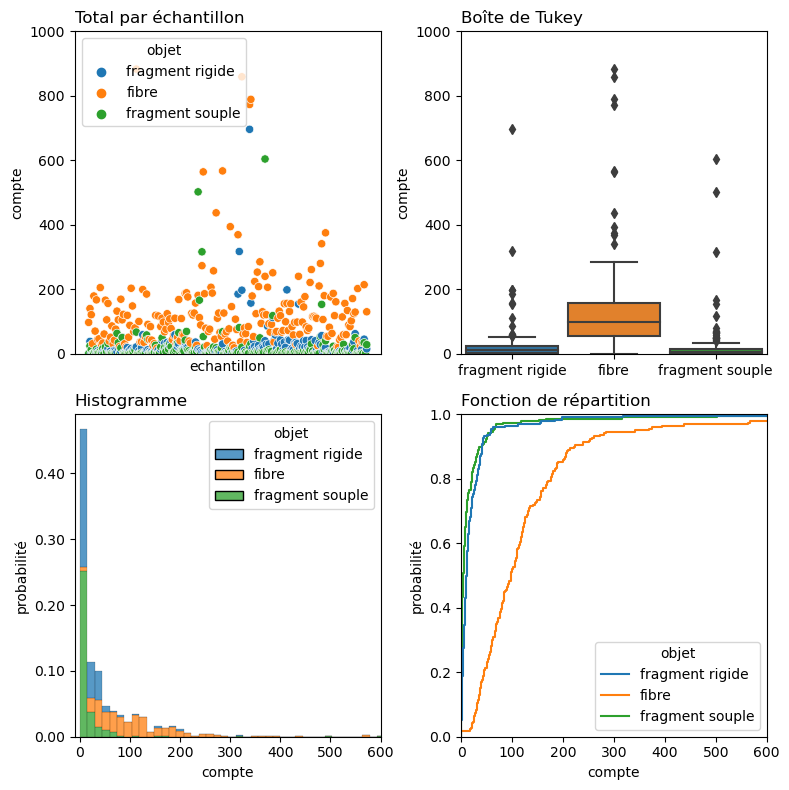

In [16]:
fig, ax = plt.subplots(2,2, figsize=(8,8))

df3["objet"] = df3["objet"].apply(lambda x: particle_groups[x])

sns.scatterplot(data=df3, x="echantillon", y="compte", hue="objet", ax=ax[0,0])
ax[0,0].tick_params(labelbottom=False, bottom=False)
ax[0,0].set_ylim(-1, 1000)
ax[0,0].set_title("Total par échantillon", loc="left")
# ax[0,0].legend().remove()

sns.boxplot(data=df3, x="objet", y="compte", hue="objet", dodge=False, width=.9, ax=ax[0,1])
ax[0,1].set_ylim(-1, 1000)
ax[0,1].set_title("Boîte de Tukey", loc="left")
ax[0,1].set_xlabel("")
ax[0,1].legend().remove()

sns.histplot(data=df3, x="compte", hue="objet", ax=ax[1,0], multiple="stack", stat="probability")
ax[1,0].set_xlim(-10, 600)
ax[1,0].yaxis.set_major_formatter('{x:.2f}')
ax[1,0].set_ylabel("probabilité")
ax[1,0].set_title("Histogramme", loc="left")



sns.ecdfplot(data=df3, x="compte", hue="objet", ax=ax[1,1])
ax[1,1].set_xlim(-1, 600)
ax[1,1].set_ylabel("probabilité")
ax[1,1].set_title("Fonction de répartition", loc="left")

plt.tight_layout()


plt.show()

### Nombre moyen par texture et position

In [17]:
position_totals = work_data.groupby(["Plage","echantillon", "position", "objet"], as_index=False).compte.sum()
position_totals["position"] = position_totals.position.apply(lambda x: name_the_zones[x])
position_totals["objet"] = position_totals.objet.apply(lambda x: particle_groups[x])


# summaries

leau_dure = position_totals[(position_totals.position == "ligne-d'eau") & (position_totals.objet == "fragment rigide")].compte.describe()
leau_souple = position_totals[(position_totals.position == "ligne-d'eau") & (position_totals.objet == "fragment souple")].compte.describe()
leau_fibre = position_totals[(position_totals.position == "ligne-d'eau") & (position_totals.objet == "fibre")].compte.describe()

leau_dure_d = translate_describe(leau_dure, "Fragments rigides").style.set_table_styles(table_css_styles).format(precision=2)
leau_souple_d = translate_describe(leau_souple, "Fragments souples").style.set_table_styles(table_css_styles).format(precision=2)
leau_fibre_d = translate_describe(leau_fibre, "Fibres").style.set_table_styles(table_css_styles).format(precision=2)
glue("leau_dure_display", leau_dure_d, display=False)
glue("leau_souple_display", leau_souple_d, display=False)
glue("leau_fibre_display", leau_fibre_d, display=False)

|ligne d'eau|ligne d'eau|ligne d'eau|
|:----------:|:----------:|:----------:|
|{glue:}`leau_dure_display`|{glue:}`leau_souple_display`|{glue:}`leau_fibre_display`|

In [18]:
plage_dure = position_totals[(position_totals.position == "plage-seche") & (position_totals.objet == "fragment rigide")].compte.describe()
plage_souple = position_totals[(position_totals.position == "plage-seche") & (position_totals.objet == "fragment souple")].compte.describe()
plage_fibre = position_totals[(position_totals.position == "plage-seche") & (position_totals.objet == "fibre")].compte.describe()

plage_dure_d = translate_describe(plage_dure, "Fragments rigides").style.set_table_styles(table_css_styles).format(precision=2)
plage_souple_d = translate_describe(plage_souple, "Fragments souples").style.set_table_styles(table_css_styles).format(precision=2)
plage_fibre_d = translate_describe(plage_fibre, "Fibres").style.set_table_styles(table_css_styles).format(precision=2)
glue("plage_dure_display", plage_dure_d, display=False)
glue("plage_souple_display", plage_souple_d, display=False)
glue("plage_fibre_display", plage_fibre_d, display=False)

|plage-seche|plage-seche|plage-seche|
|:----------:|:----------:|:----------:|
|{glue:}`plage_dure_display`|{glue:}`plage_souple_display`|{glue:}`plage_fibre_display`|

In [19]:

df4 = position_totals.groupby(["Plage","position", "objet"], as_index=False).compte.mean()

df4 = df4.pivot(index="Plage", columns=["position", "objet"])
df4.index.name = None
df4.columns
# df4.fillna(0, inplace=True)

def select_a_set_of_values(data, column_one, search_index, search_value, average_of_sample_textures):
    
    return data.loc[data[column_one] > average_of_sample_textures.loc[search_index, search_value]]

args_one = [("compte", position_columns[0], x) for x in fragment_columns]
args_two = [("compte", position_columns[1], x) for x in fragment_columns]

args_0 = select_a_set_of_values(df4, args_one[0], list(particle_groups.keys())[0], value_column, average_of_sample_textures).index
args_1 = select_a_set_of_values(df4, args_one[1], list(particle_groups.keys())[1], value_column, average_of_sample_textures).index
args_2  = select_a_set_of_values(df4, args_one[2], list(particle_groups.keys())[2], value_column, average_of_sample_textures).index

args_2_0 = select_a_set_of_values(df4, args_two[0], list(particle_groups.keys())[0], value_column, average_of_sample_textures).index
args_2_1 = select_a_set_of_values(df4, args_two[1], list(particle_groups.keys())[1], value_column, average_of_sample_textures).index
args_2_2 = select_a_set_of_values(df4, args_two[2], list(particle_groups.keys())[2], value_column, average_of_sample_textures).index

sax = df4.style.set_table_styles(table_css_styles).set_caption(caption).format(precision=2)
  
sax = sax.set_properties(subset = pd.IndexSlice[args_2, args_one[2]],**a_property)
sax = sax.set_properties(subset = pd.IndexSlice[args_1,args_one[1]],**a_property)
sax = sax.set_properties(subset = pd.IndexSlice[args_0,args_one[0]], **a_property)
sax = sax.set_properties(subset = pd.IndexSlice[args_2_2, args_two[2]], **a_property)
sax = sax.set_properties(subset = pd.IndexSlice[args_2_1,args_two[1]],**a_property)
sax = sax.set_properties(subset = pd.IndexSlice[args_2_0,args_two[0]], **a_property)

sax

### Distributions



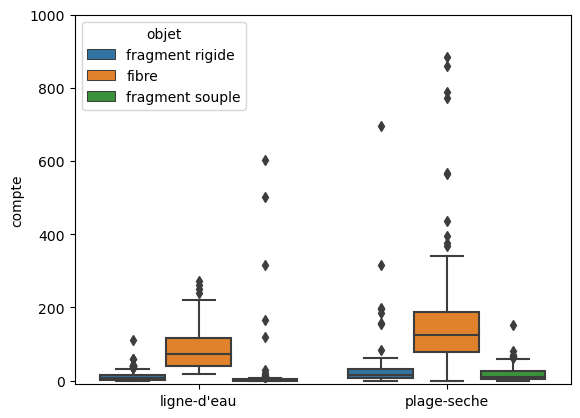

In [20]:
fig, ax = plt.subplots(1)

sns.boxplot(data=position_totals, x="position", y="compte", hue="objet", ax=ax)
# sns.boxplot(data=position_totals, x="objet", y="compte", hue="objet",ax=ax[1])

ax.set_ylim(-10, 1000)
ax.set_xlabel("")

plt.show()